In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn
import gensim.corpora as corpora
import gensim
import string
import pyLDAvis
import pyLDAvis.gensim_models
import langid
import random

from matplotlib import pyplot as plt
from pprint import pprint
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, BertTokenizer, BertModel, pipeline, get_linear_schedule_with_warmup
)
from datasets import Dataset
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic
from IPython.display import Image

torch.manual_seed(42)
torch.backends.cuda.deterministic = True

%matplotlib inline

# Agenda

1. [Load and Preprocess Data](#Load_and_Preprocess_Data)
2. [Clustering Algorithms](#Clustering_Algorithms)
3. [Dimensionality Reduction](#Dimensionality_Reduction) 
3. [Text Embeddings clustering](#Text_Embeddings_clustering)
4. [Topic Modelling](#Topic_Modelling)
4. [Homework](#Homework)

# Resources
- https://scikit-learn.org/stable/modules/clustering.html
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- https://en.wikipedia.org/wiki/Convex_set
- https://en.wikipedia.org/wiki/Isotropy
- https://en.wikipedia.org/wiki/Principal_component_analysis
- https://scikit-learn.org/stable/modules/decomposition.html#pca
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN
- https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA
- https://radimrehurek.com/gensim/models/ldamodel.html
- https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation
- https://github.com/MaartenGr/BERTopic
- https://maartengr.github.io/BERTopic/index.html

# Introduction

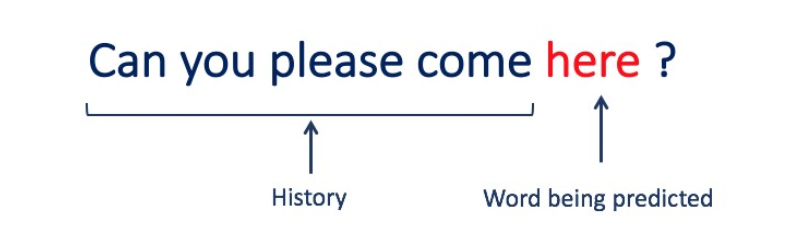

In [2]:
Image("images/Screenshot from 2023-10-31 12-38-43.png")

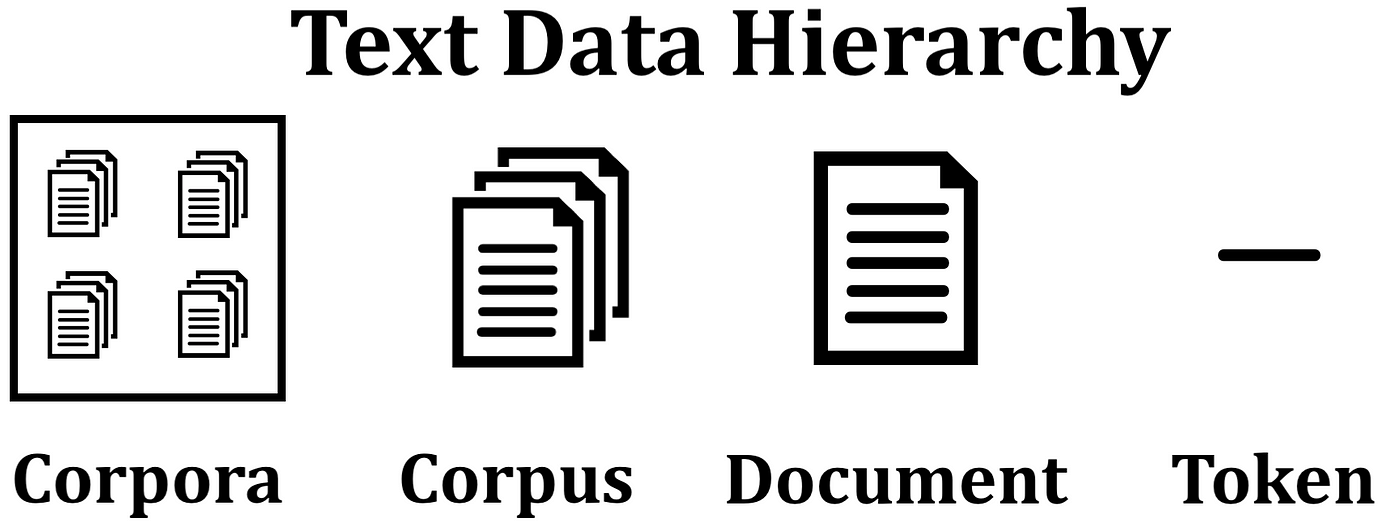

In [3]:
Image("images/1 f9XQxMUDkYkquZDDcccEJA.png")

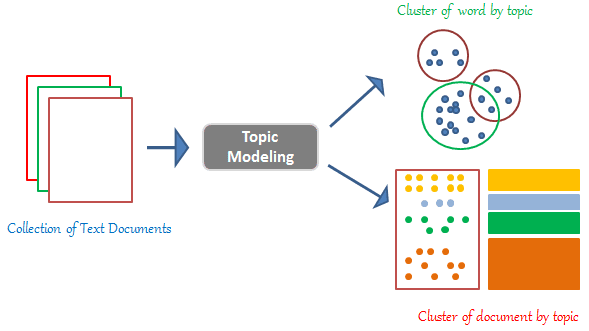

In [4]:
Image(
    "images/4519707623a1e07ae153046bc387e0136a65f.image001-min.png"
)

Let's consider another approach to NLP task classification:
1. Work only with one sequence
    - Classification
    - Generation
    - ...
2. Work with Corpus or Corpora
     - Text clustering and Topic modeling
  
The first class tasks and approaches are well-studied: A good example is LLM, which is a kind of "universal" model

The second class is much more problematic. How can we approach it? 
1. Using the "teapot approach" (not sure that it is correctly named in English): Join the whole corpus into one long sequence and apply LLM.
    - May work with a small corpus
    - Will fail with big (real life) case corpus and corpora
2. Propose other approaches, which can handle each document as a separate instance 

<a id='Load_and_Preprocess_Data'></a>
# Load and Preprocess Data

In [5]:
df = pd.read_csv("../data/KyivChannels_Dataset_v01.csv", converters={"Date": pd.to_datetime})

In [6]:
df.head()

channelname                Date  \
0  kyivpolitics 2023-08-01 09:45:38   
1  kyivpolitics 2023-08-01 10:03:38   
2  kyivpolitics 2023-08-01 14:42:31   
3  kyivpolitics 2023-08-01 15:37:34   
4  kyivpolitics 2023-08-01 13:06:08   

                                             content lang  
0  Отбой. Угрозы для столицы нет\n\nКиев. Главное...   ru  
1  На 8 перекрестках Киева в пилотном режиме внед...   ru  
2  ⚡️НБУ отозвал банковскую лицензию Конкорд Банк...   ru  
3  Завтра синоптики прогнозируют небольшой дождь ...   ru  
4  А вот и сам снятый советский герб \n\nКиев. Гл...   ru

In [7]:
df.shape

(31182, 4)

In [8]:
df.isna().sum(axis=0)

channelname    0
Date           0
content        0
lang           0
dtype: int64

In [9]:
df["channelname"].value_counts()

channelname
novynylive                     3590
lossolomas_kyiv                3009
darnicalive                    2715
kievvlast                      2273
vichirniykyiv                  1738
big_kyiv                       1670
kyivpolitics                   1383
nashkyivua                     1366
kyiv_novyny_24                 1102
kievreal1                      1096
huevyi_kiev                    1091
obolonlife                     1070
kiev1                          1006
khreschatyk36                   959
kyiv_n                          809
lisovy_masyv_official           722
poznyakyosokorkykharkivskiy     633
hmarochos                       606
ushkiklichko                    578
semenovatut                     526
kyivpasstrans                   362
kyivpatrol                      313
kyivpastrans_live               280
kyivpassengers                  277
uhmc2022                        271
kyiv_pro_office                 248
kyivcityofficial                247
kyiv_by_grishyn 

In [10]:
# def detect_language(text):
#     lang, _ = langid.classify(text)
#     return lang

# df["lang"] = df["content"].apply(detect_language)
df["lang"].value_counts()

lang
uk    28465
ru     2112
en      147
bg       95
sr       77
be       58
ja       53
kk       39
zh       30
mk       23
mn       22
vi        8
ky        7
pl        5
sk        4
hr        3
qu        3
rw        3
bs        3
bn        2
fi        2
mt        2
ka        2
he        2
de        2
sq        1
mr        1
it        1
da        1
ps        1
sv        1
sl        1
fr        1
nn        1
et        1
hu        1
zu        1
hi        1
Name: count, dtype: int64

## Date dependency 

In [11]:
df["Date_day"] = df["Date"].apply(lambda x: x.date())

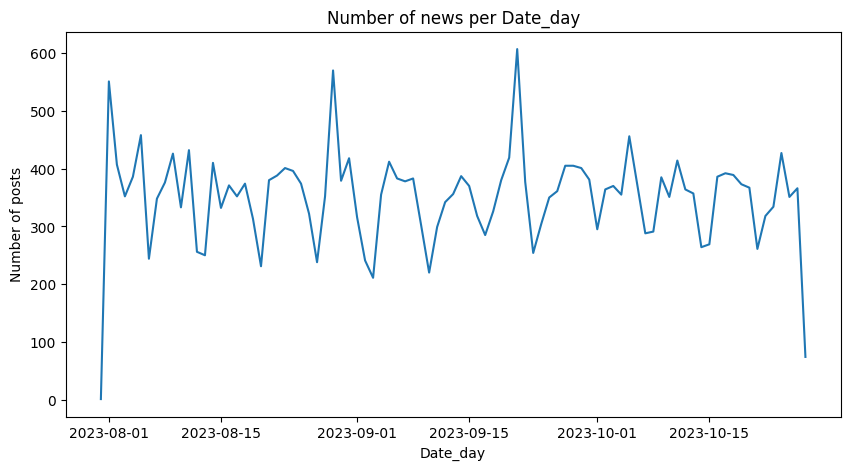

In [12]:
plt.figure(figsize=(10,5))
plt.title("Number of news per Date_day")
df.groupby("Date_day")["content"].count().plot()
plt.xlabel("Date_day")
plt.ylabel("Number of posts")
plt.show()

## Text Visualisation

In [13]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /home/vova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/vova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

def process_text(input):
    if isinstance(input, str):
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
    return input

df["content_processed"] = df["content"].apply(process_text)

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/tmp/ipykernel_3494110/2094041440.py:3: DeprecationWarning: invalid escape sequence '\.'
  input = re.sub("\.+", ".", input)


In [15]:
def read_txt_to_list(path):
    with open(path, 'r') as file:
        lines = file.readlines()
    return [line.strip() for line in lines]

nltk.download("stopwords")

ru_stopwords = stopwords.words("russian")
# Taken from https://raw.githubusercontent.com/skupriienko/Ukrainian-Stopwords/master/stopwords_ua.txt 
ua_stopwords = read_txt_to_list("stopwords_ua.txt")

[nltk_data] Downloading package stopwords to /home/vova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/vova/src/exps/iasa_nlp_course/.venv/lib/python3.10/site-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


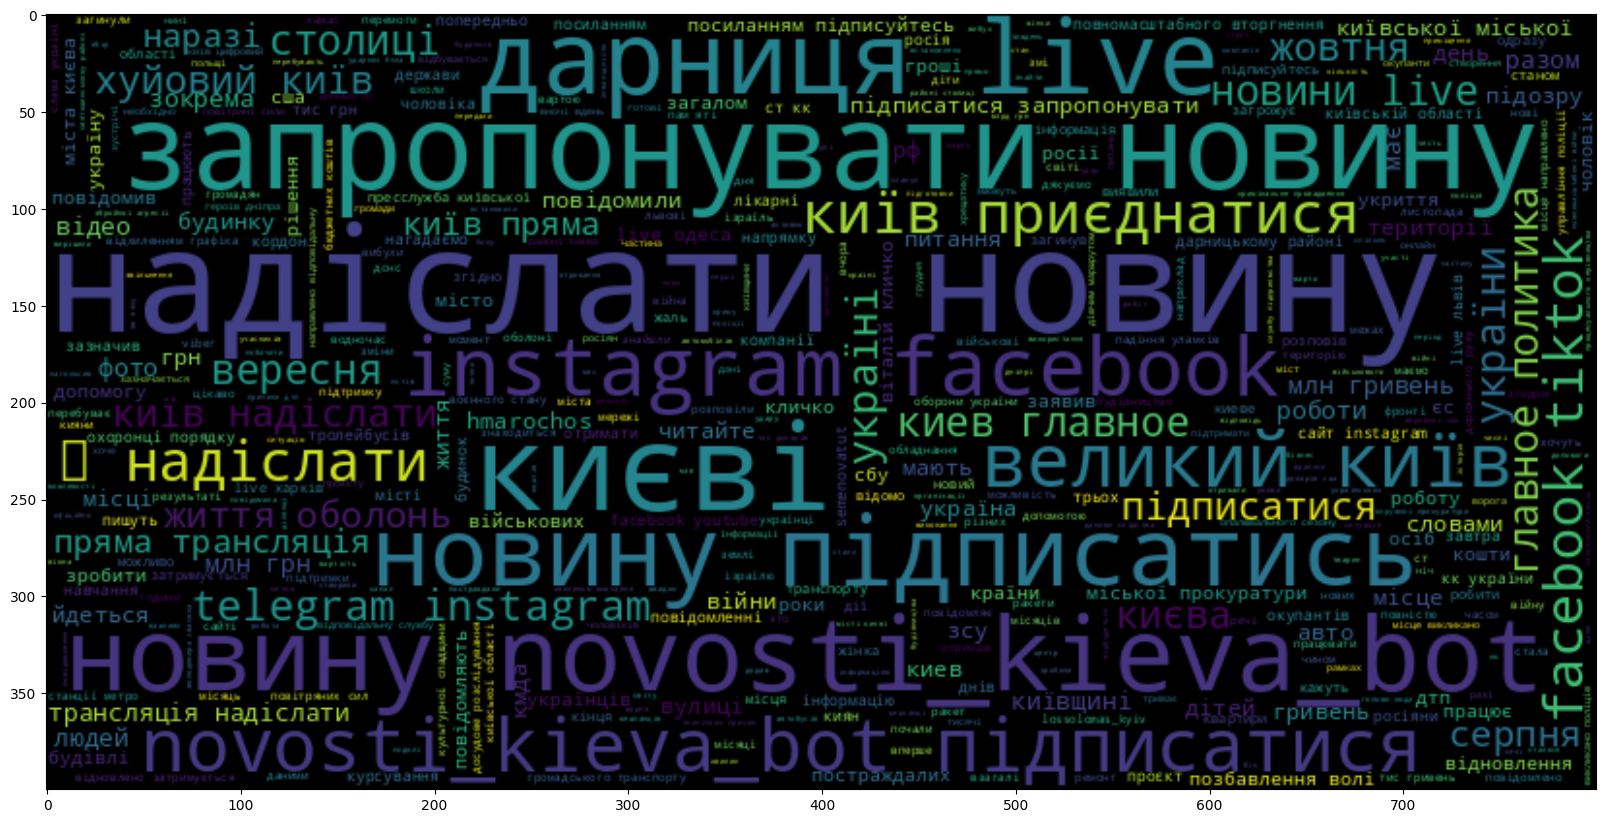

In [16]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(
    max_words = 500, 
    width = 800, 
    height = 400, 
    stopwords = ru_stopwords + ua_stopwords).generate(" ".join(df["content_processed"].apply(lambda x: x.lower())))
plt.imshow(wc, interpolation = 'bilinear')

> **TODO**: Continue text cleaning. Obvious ideas: filter emojis and extend stopwords

## Extract Text embeddings

In [17]:
sent_emb_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-mpnet-base-v2", device="cuda",)

> **TODO**: Search for better Sentance Embedding model

In [18]:
# sent_embeddings = sent_emb_model.encode(df["content_processed"].to_list(), batch_size=100)

# np.save(
#     "../data/KyivChannels_Dataset_v01_sent_embeddings.npy",
#     sent_embeddings
# )

In [19]:
sent_embeddings = np.load("../data/KyivChannels_Dataset_v01_sent_embeddings.npy")
assert sent_embeddings.shape[0] == df.shape[0]

<a id='Clustering_Algorithms'></a>
# [Clustering Algorithms](https://scikit-learn.org/stable/modules/clustering.html)

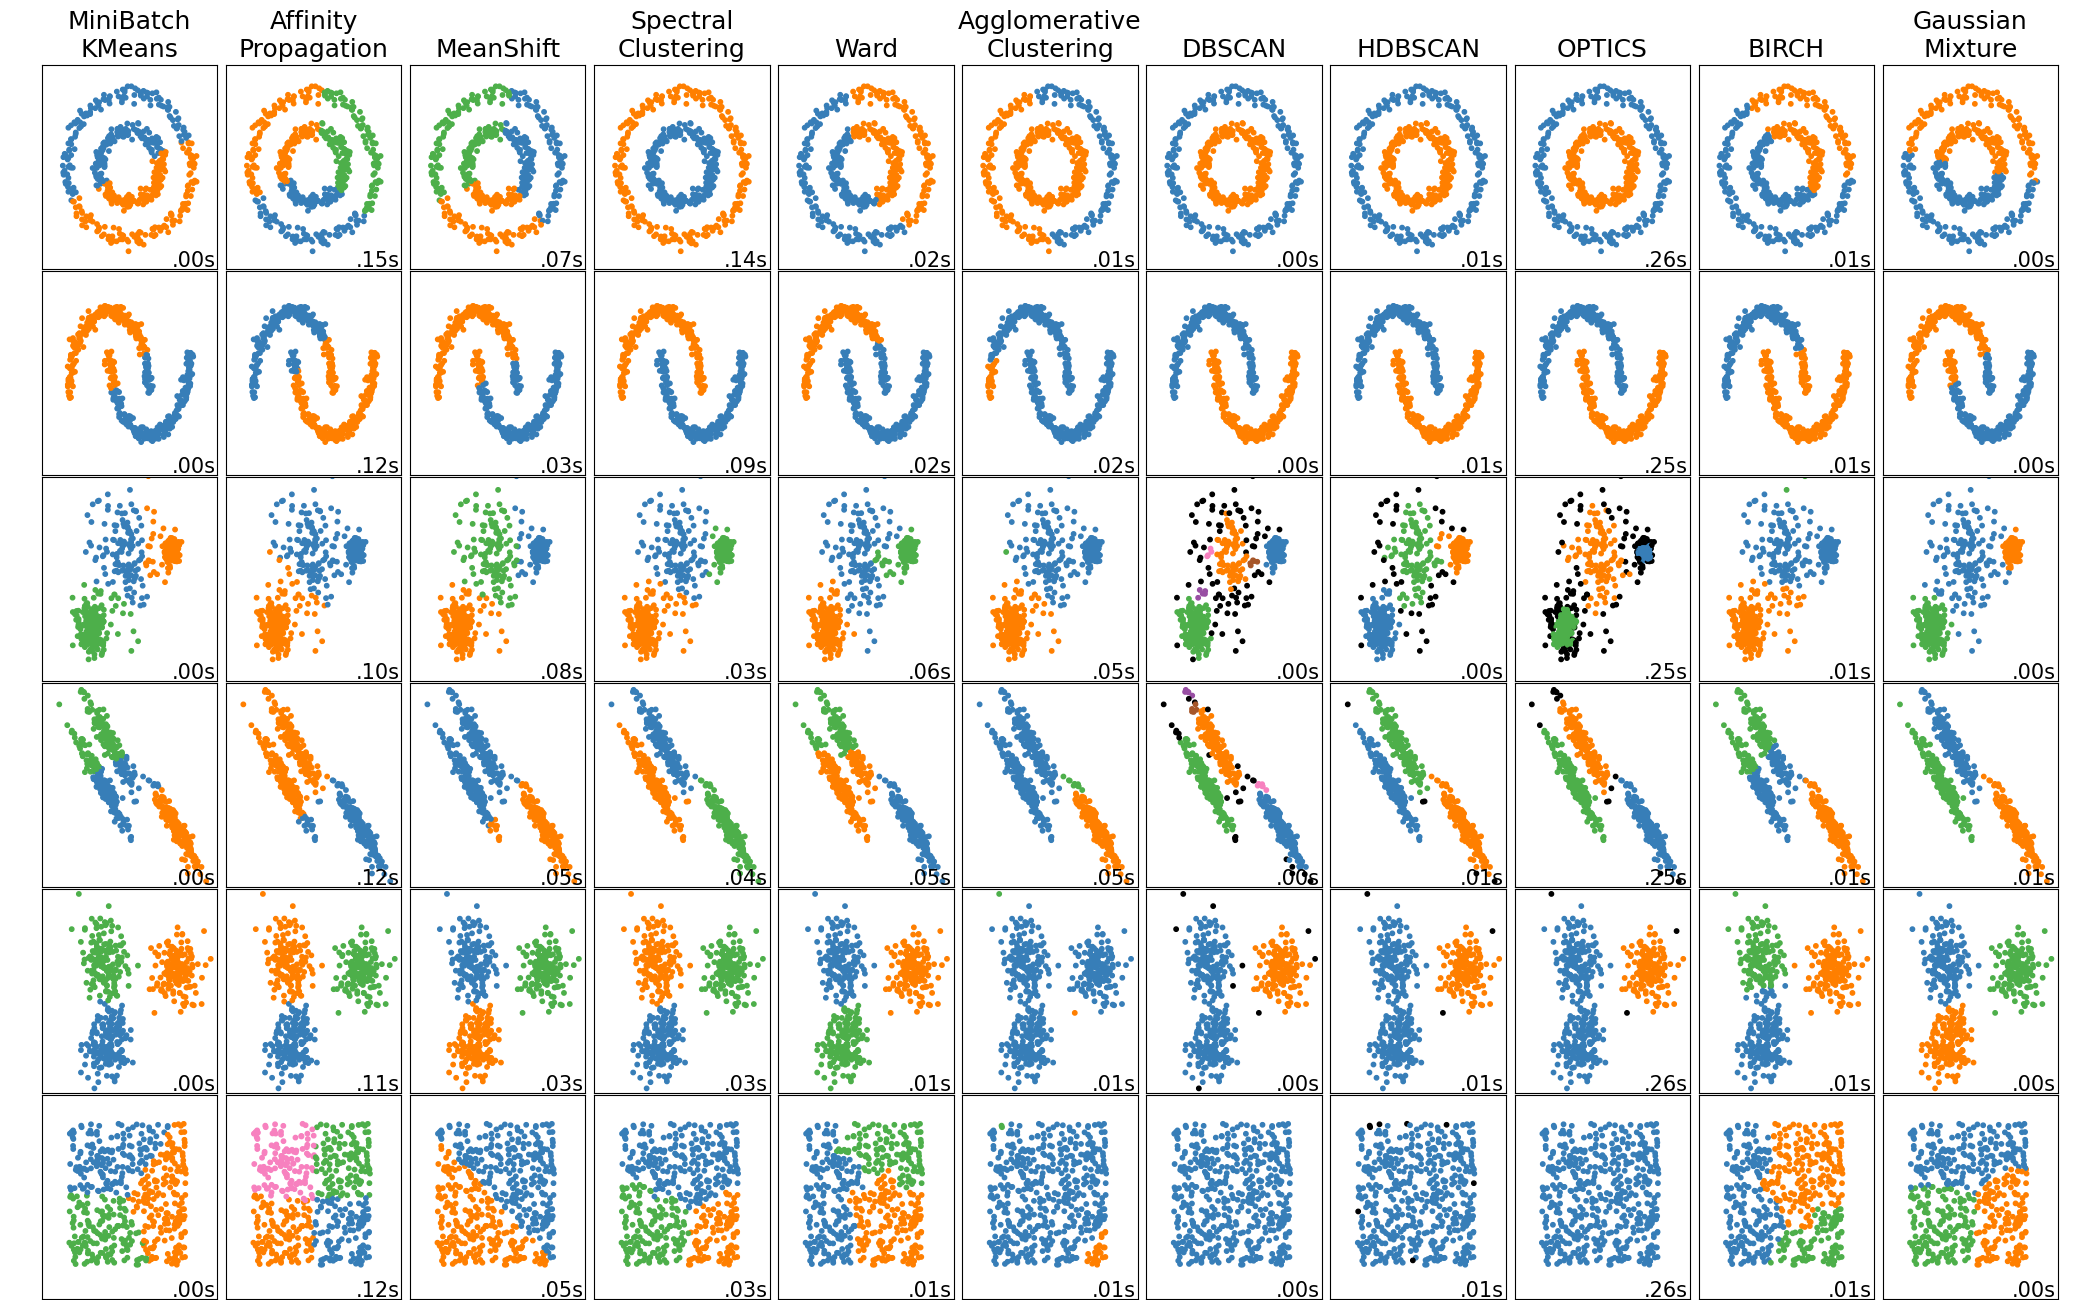

In [51]:
Image("images/sphx_glr_plot_cluster_comparison_001.png")

## [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

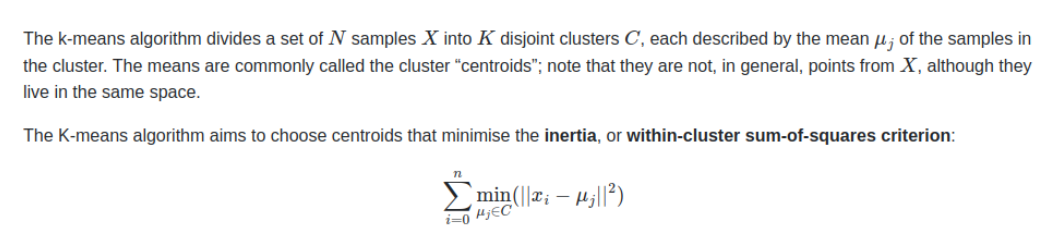

In [50]:
Image("images/Screenshot from 2023-11-05 21-59-27.png")

Inertia can be recognized as a measure of how internally coherent clusters are. It suffers from various drawbacks:
- Inertia makes the assumption that clusters are [convex](https://en.wikipedia.org/wiki/Convex_set) and [isotropic](https://en.wikipedia.org/wiki/Isotropy), which is not always the case. It responds poorly to elongated clusters, or manifolds with irregular shapes.
- Inertia is not a normalized metric: we just know that lower values are better and zero is optimal. But in very high-dimensional spaces, Euclidean distances tend to become inflated (this is an instance of the so-called “curse of dimensionality”). Running a dimensionality reduction algorithm such as [Principal component analysis (PCA)](https://scikit-learn.org/stable/modules/decomposition.html#pca) prior to k-means clustering can alleviate this problem and speed up the computations.

**CONVEX**

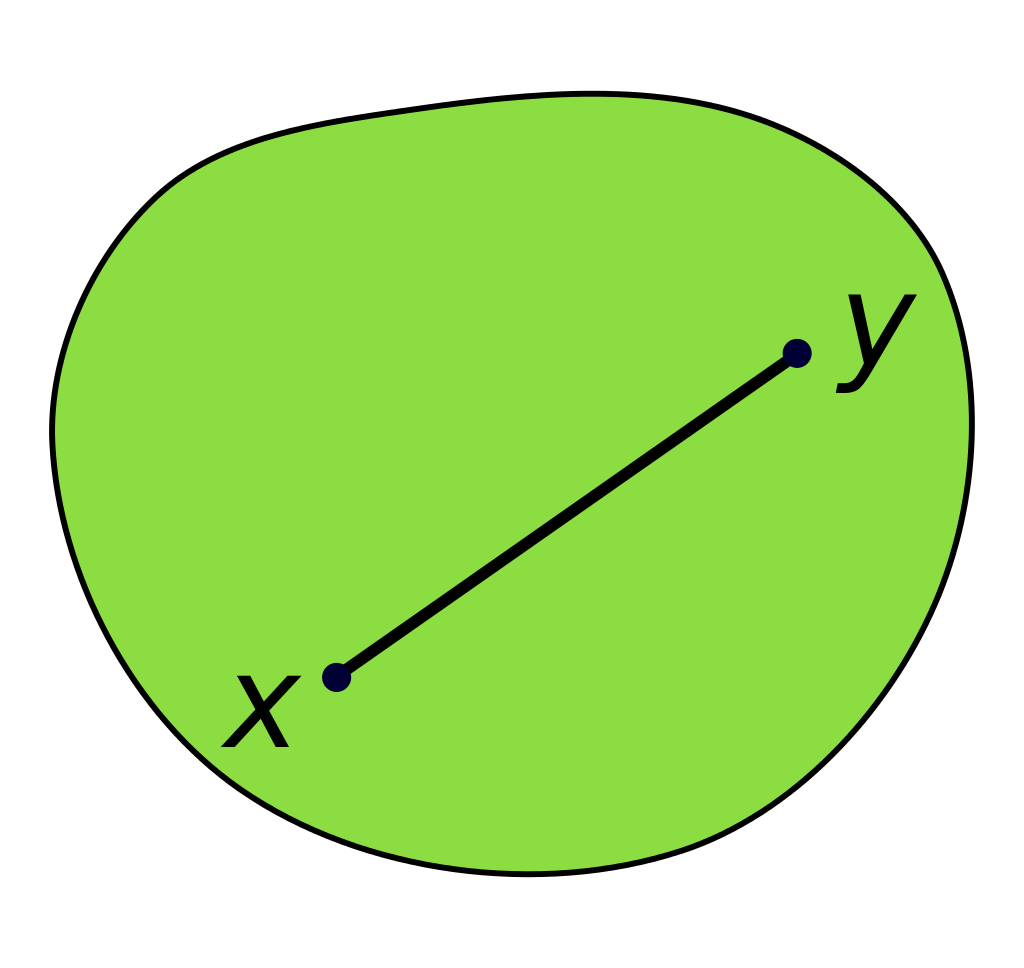

In [47]:
Image("images/Convex_polygon_illustration1.svg.png")

**NON CONVEX**

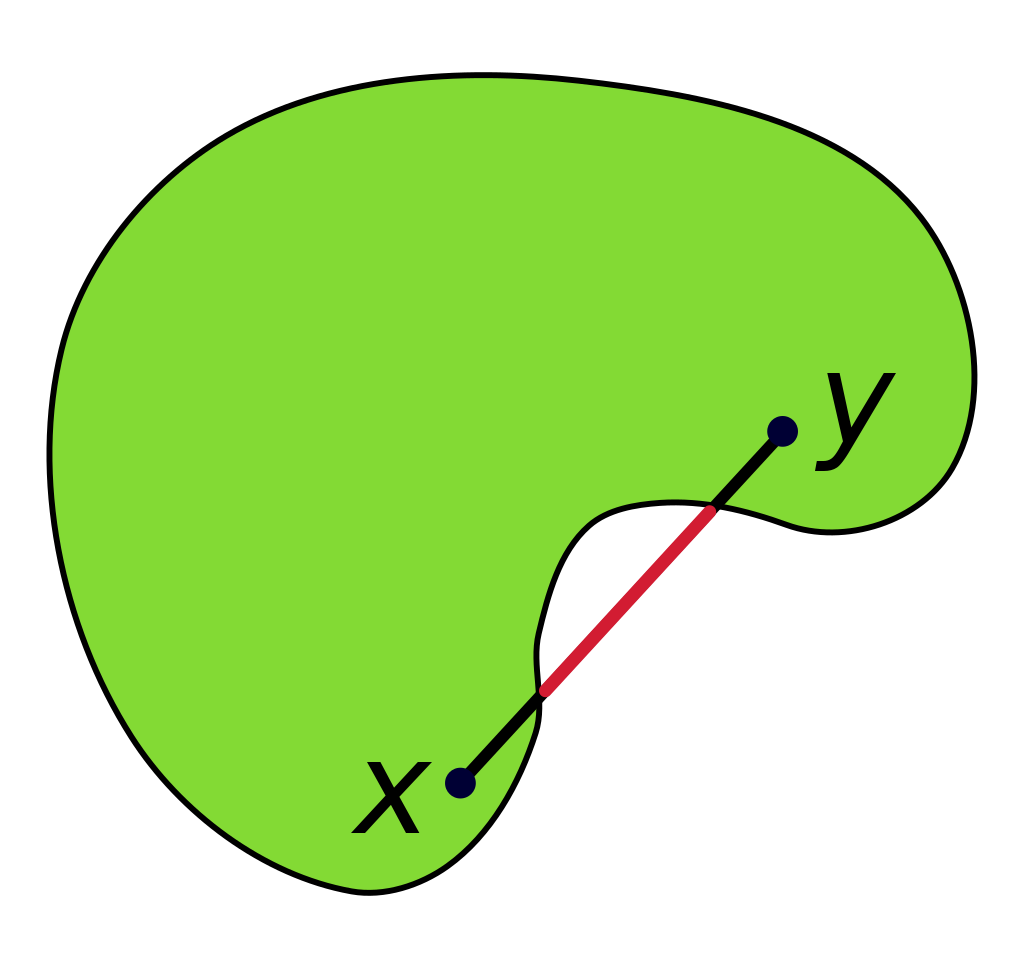

In [48]:
Image("images/1024px-Convex_polygon_illustration2.svg.png")

## [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)

The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped. The central component to the DBSCAN is the concept of core samples, which are samples that are in areas of high density. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples). There are two parameters to the algorithm, `min_samples` and `eps`, which define formally what we mean when we say dense. Higher `min_samples` or lower`eps` indicate higher density necessary to form a cluster.

More formally, we define a core sample as being a sample in the dataset such that there exist `min_samples` other samples within a distance of `eps`, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples. Intuitively, these samples are on the fringes of a cluster.

Any core sample is part of a cluster, by definition. Any sample that is not a core sample, and is at least `eps` in distance from any core sample, is considered an outlier by the algorithm.

<a id='Dimensionality_Reduction'></a>
# Dimensionality Reduction

## [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

[Principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) is a popular technique for analyzing large datasets containing a high number of dimensions/features per observation, increasing the interpretability of data while preserving the maximum amount of information, and enabling the visualization of multidimensional data. Formally, PCA is a statistical technique for reducing the dimensionality of a dataset. This is accomplished by linearly transforming the data into a new coordinate system where (most of) the variation in the data can be described with fewer dimensions than the initial data. Many studies use the first two principal components in order to plot the data in two dimensions and to visually identify clusters of closely related data points

**PCA of a multivariate Gaussian distribution centered at (1,3) with a standard deviation of 3 in roughly the (0.866, 0.5) direction and of 1 in the orthogonal direction. The vectors shown are the eigenvectors of the covariance matrix scaled by the square root of the corresponding eigenvalue, and shifted so their tails are at the mean.**

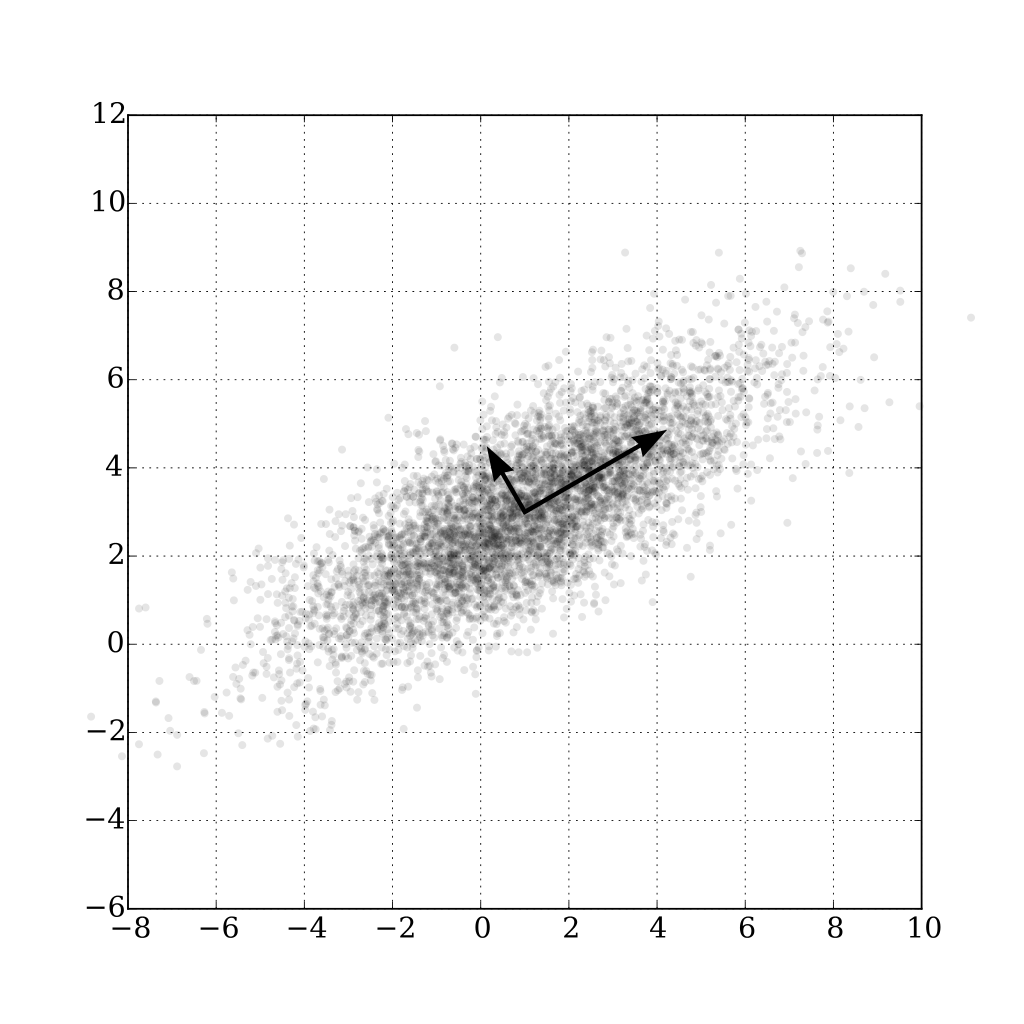

In [46]:
Image("images/GaussianScatterPCA.svg.png")

## [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

[t-distributed stochastic neighbor embedding (t-SNE)](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) is a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map. It is based on Stochastic Neighbor Embedding. It is a nonlinear dimensionality reduction technique well-suited for embedding high-dimensional data for visualization in a low-dimensional space of two or three dimensions. Specifically, it models each high-dimensional object by a two- or three-dimensional point in such a way that similar objects are modeled by nearby points and dissimilar objects are modeled by distant points with high probability. 

**T-SNE embeddings of MNIST dataset**

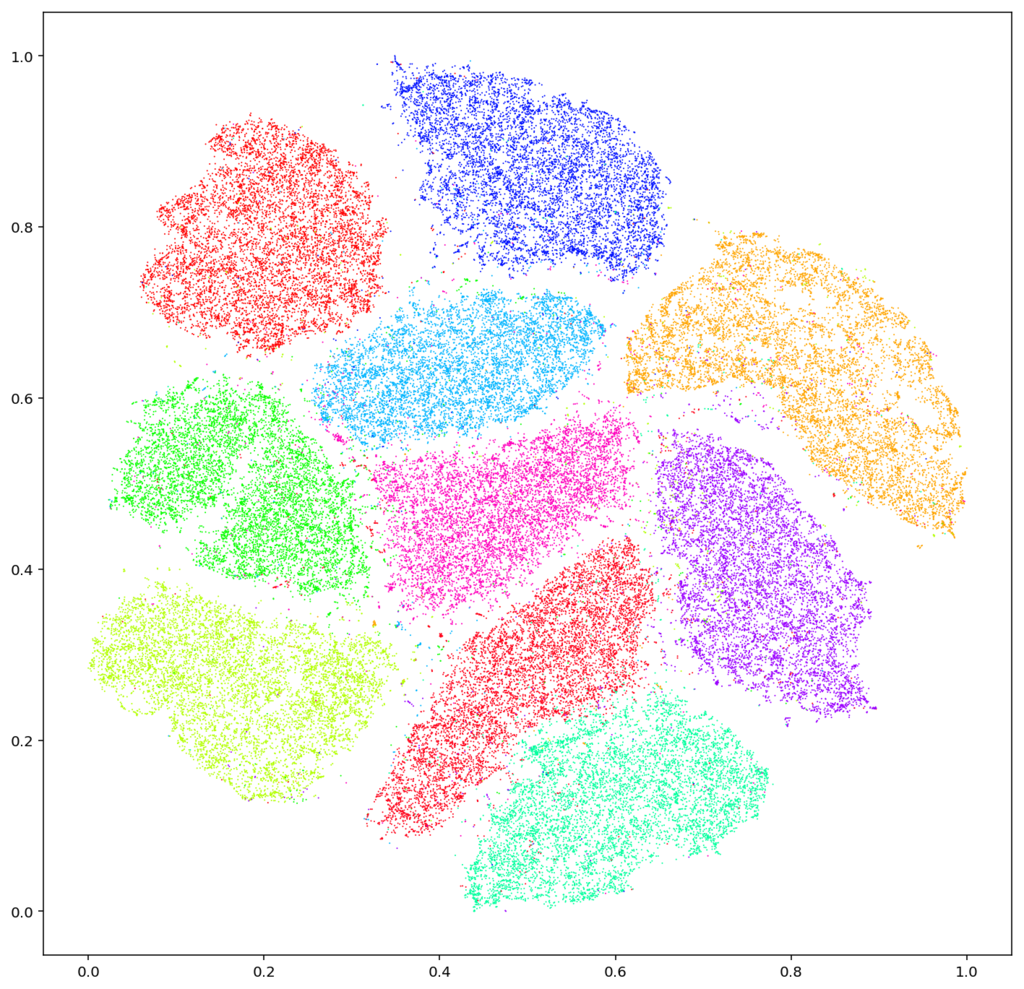

In [45]:
Image("images/T-SNE_Embedding_of_MNIST.png")

<a id='Text_Embeddings_clustering'></a>
# Text Embeddings clustering

## Pipeline 

1. Take some Texts
2. Aplly TSNE and visualize 
3. According to visualization - pick the number of Clusters for KMeans.
4. Examine KMeans clusters 
5. Try to estimate the optimal distance threshold for DBSCAN from KMeans clusters 
6. Examine DBSCAN clusters 

> **TODO**: Try to pick n_clusters using [clustering metrics](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation)

> **TODO**: Try to repeat this Pipeline in placing TSNE with PCA on the first step 

In [20]:
df.index

RangeIndex(start=0, stop=31182, step=1)

In [21]:
# index_without_duplicates = df.drop_duplicates("content_processed").index
# random_ids = random.sample(range(0, len(index_without_duplicates)), 3000)
# random_ids = index_without_duplicates[random_ids].to_list()
# np.save(
#     "../data/KyivChannels_Dataset_v01_random_ids.npy",
#     np.array(random_ids)
# )

In [22]:
random_ids = np.load("../data/KyivChannels_Dataset_v01_random_ids.npy")

In [23]:
df["channelname"].iloc[random_ids].value_counts()

channelname
novynylive                     364
lossolomas_kyiv                278
darnicalive                    256
kievvlast                      200
big_kyiv                       190
vichirniykyiv                  163
nashkyivua                     140
kyivpolitics                   139
obolonlife                     111
kyiv_novyny_24                 107
huevyi_kiev                    106
kiev1                          105
kievreal1                      102
khreschatyk36                   96
kyiv_n                          72
lisovy_masyv_official           61
poznyakyosokorkykharkivskiy     57
hmarochos                       57
semenovatut                     53
ushkiklichko                    49
kyivpasstrans                   34
kyivpatrol                      33
kyivcityofficial                27
kyivpastrans_live               26
uhmc2022                        25
kyiv_pro_office                 24
kyiv_by_grishyn                 21
kyivpassengers                  20
pro_mobi

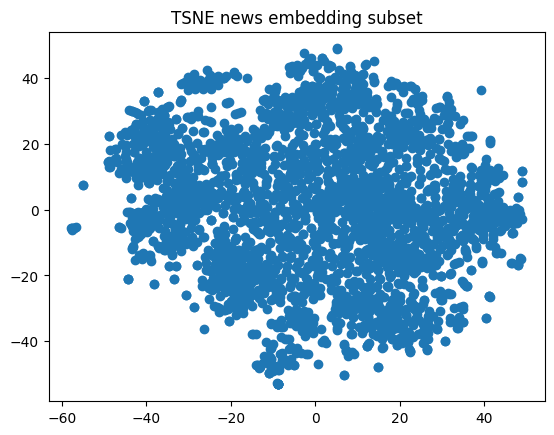

In [24]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(sent_embeddings[random_ids])

plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

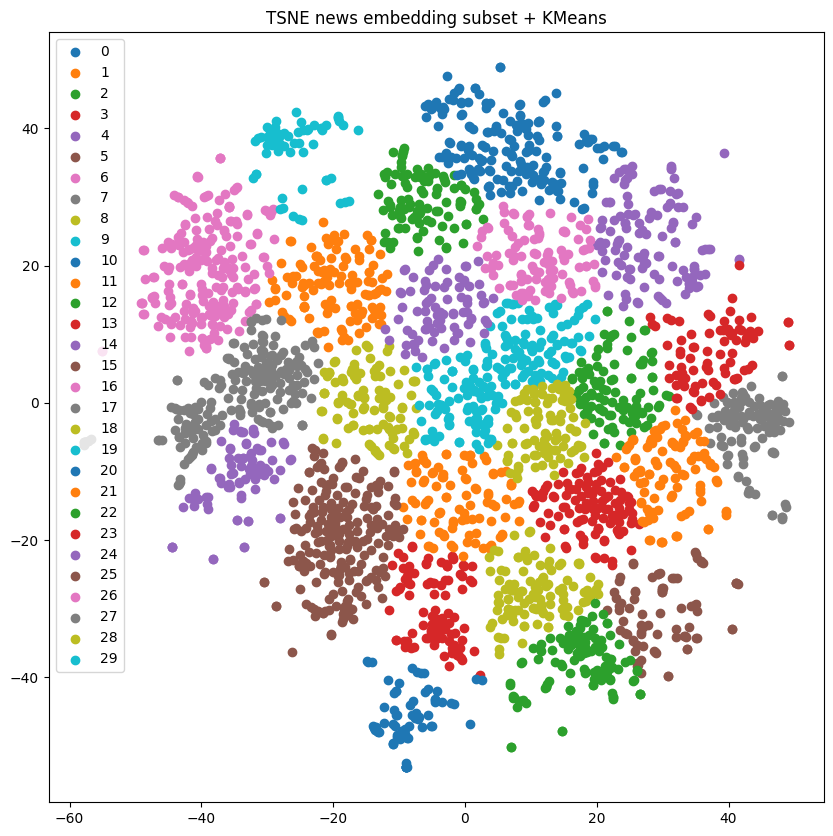

In [25]:
kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=30, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10,10))
plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [26]:
df.iloc[random_ids][kmeans_clusts_news_embeddings_subset == 0].content.to_list()[:8]

['Начальницю відділу Управління освіти Дніпровської РДА, яка закупляла овочерізки в укриття, відсторонено від посади\n\nРішення ухвалив Голосіївський районний суд м. Києва\nㅤ\n🇺🇦 Киев Сейчас',
 'Ґданський котел: адвокат АЗС "Авантаж" проти військових у Господарському суді\n\n16 жовтня у Господарському суді міста Києва розгорівся скандал у справі колишніх партнерів ТОВ "Електроенерджі" (група АЗС "Авантаж") за участі адвоката товариства.\n\nПід час засідання представниця підприємства почала дивно себе поводити, заявляти про тиск з боку журналістів та військових на суд, які прийшли не допустити привласнення активів бенефіціарами пов\'язаними з росією, а також почала розповідати про те, як займається конфіскацією активів рф та працює на користь України.\n\nВ свою чергу головуюча суддя Удалова під час засідання спростувала заяви адвоката про якийсь тиск та повідомила, що на сьогодні жодні сторонні особи на суд не впливають, що було помітно по поведінці судді у судовому засіданні.\n\nЦікаво

In [27]:
df.iloc[random_ids][kmeans_clusts_news_embeddings_subset == 17].content.to_list()[:8]

['РФ обстріляла з танків житловий будинок в Авдіївці, сталася пожежа, — ОВА \n\nПостраждалих на місці немає. Мешканці будинку виїхали. Сьогодні місто вже двічі атакували з танків, також завдавали ударів з артилерії та «Градів», додали в адміністрації.   \n \nФото: Донецька ОВА',
 'У Чернігові завершилася пошуково-рятувальна операція \n\n136 постраждалих внаслідок російського удару. 7 загиблих.\xa0 129 поранених, з яких 15 дітей та 15 співробітників поліції\n\n19-21 у місті оголошено жалобу 🕯️\n\nПідписатися\xa0\xa0\xa0 |\xa0\xa0\xa0 Запропонувати новину',
 'Внаслідок обстрілу Харківщини поранено 14-річного хлопця\n\nОкупанти обстріляли село Бугаївка Чугуївського району.\n\nЗа даними Синєгубова, осколкових поранень зазнали 14-річний хлопець та 62-річна жінка. Вони госпіталізовані та отримують необхідну допомогу лікарів.\n\nТакож при обстрілі кілька осколків влучили в автомобіль швидкої допомоги. На щастя, бригада медиків не постраждала. \n\n🇺🇦 Новини.LIVE Харків',
 "Друзі, загалом всі м

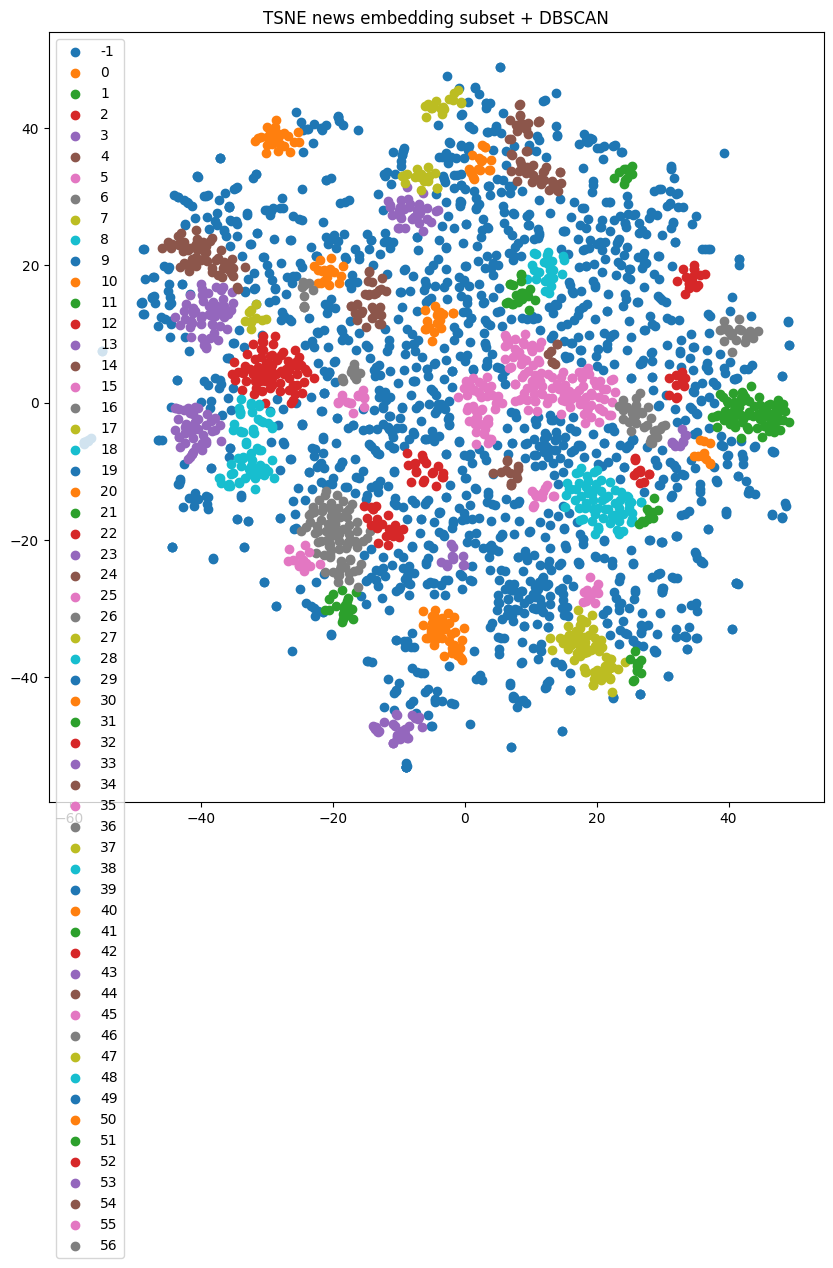

In [28]:
dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=2,
    min_samples=10
).fit_predict(tsne_news_embeddings_subset)

plt.figure(figsize=(10,10))
plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

In [29]:
df.iloc[random_ids][dbscan_clusts_news_embeddings_subset == 0].content.to_list()[:8]

['На севере Украины увеличивают количество мобильных огневых групп, — Наев\n\nПо его словам, это нужно для того, чтобы повысить эффективность системы ПВО и чтобы каждый украинец чувствовал себя защищенным, а наши объекты энергетической инфраструктуры в условиях зимы были готовы работать по полной.\n\nКиев. Главное. Политика',
 "Київщина на 85% готова до опалювального сезону, — КОВА\n\n1179 котелень підготовлено до старту роботи. Об'єкти критичної інфраструктури та соціального призначення забезпечують генераторами – понад 6 тис.\n\n🇺🇦 Киев Сейчас",
 'У ДТЕК розповіли про підготовку до зими\n\nУкраїнська енергетика має низку важливих викликів на цю зиму через терор рф. Щоб уникнути енергетичного колапсу, у ДТЕК розробили нестандартні заходи.\nПро них детальніше розповів генеральний директор компанії Віталій Шайда.\n\nВін зазначив, що ДТЕК фізично захистило своє силове обладнання в Київській області. А саме, трансформаторні підстанції, які забезпечують діяльність регіону. Також збільшили 

In [30]:
df.iloc[random_ids][dbscan_clusts_news_embeddings_subset == 1].content.to_list()[:8]

['Вечірній птах з Оболонського муралу всім бажає тихої і доброї ночі!\n\nЖиття\U0001faf6Оболонь',
 'Супер вечір, Оболонь.\n\nЖиття\U0001faf6Оболонь',
 'Гарного вечора шановні \U0001faf6\n\n\n———————————————\n#Київпастранс_LIVE \n\n📷Даня Гайдай',
 'Тихої ночі Оболонь🙏\n\nЖиття\U0001faf6Оболонь',
 'Нехай неділя буде для всіх такою, незважаючи на ваші ділові костюми і краватки - лінощів та розваг всім.',
 'Гарного вечора, район! \U0001fae1',
 'Пізній вечір з 1 мікрорайону.\n\nЖиття\U0001faf6Оболонь',
 'Добраніч. \n\n@semenovatut']

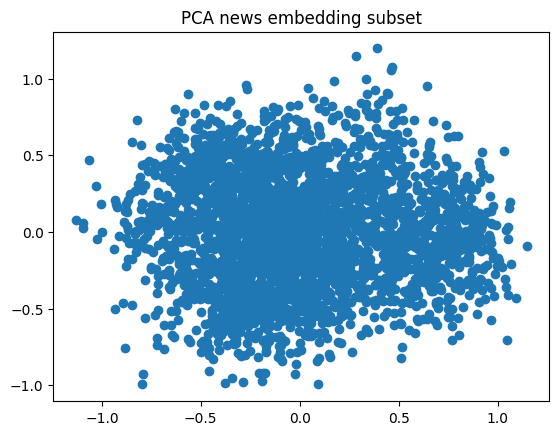

In [31]:
pca_news_embeddings_subset = PCA(random_state=42).fit_transform(sent_embeddings[random_ids])

plt.title("PCA news embedding subset")
plt.scatter(pca_news_embeddings_subset[:,0], pca_news_embeddings_subset[:,1])
plt.show()

## Conclusions 

**Use Cases**
- Contextual duplicates merging
- Text exploratary data analysis

**Main Problems**
- It is hard to say that it works :) 
- Requires hard hyper-parameter tunning  
- Optimal parameters for one subset may not be optimal for another one
- Lacks some good metrics 
- Hardly rely on the shape of dataspace

<a id='Topic_Modelling'></a>
# Topic Modelling

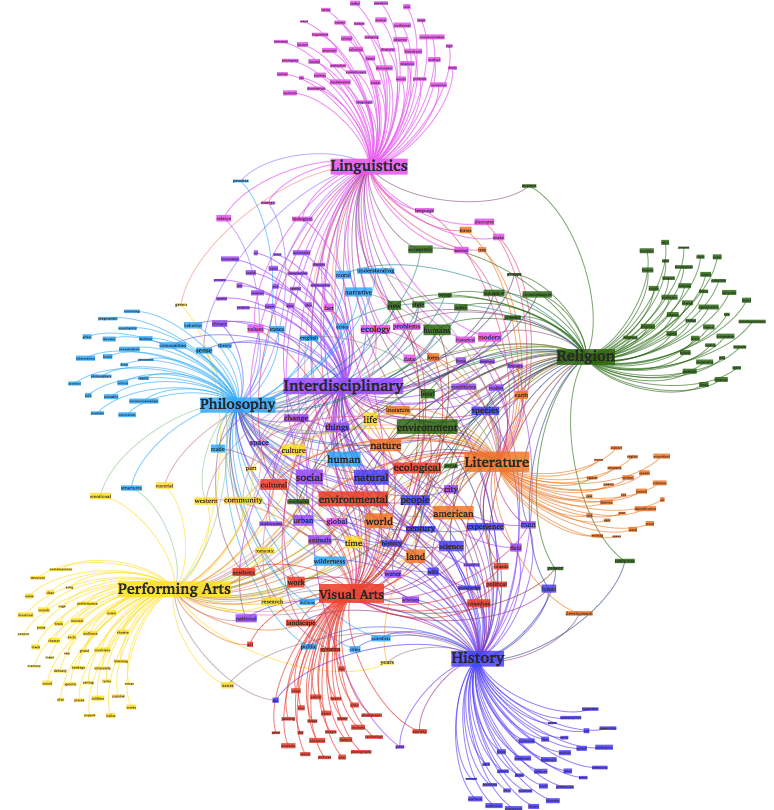

In [44]:
Image("images/1 _ZMgTsJGmR743ngZ7UxN9w.png")

## [LDA Model](https://radimrehurek.com/gensim/models/ldamodel.html)

[Latent Dirichlet allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf)

In natural language processing, Latent Dirichlet Allocation (LDA) is a generative statistical model that explains a set of observations through unobserved groups, and each group explains why some parts of the data are similar. The LDA is an example of a topic model. In this, observations (e.g., words) are collected into documents, and each word's presence is attributable to one of the document's topics. Each document will contain a small number of topics. 

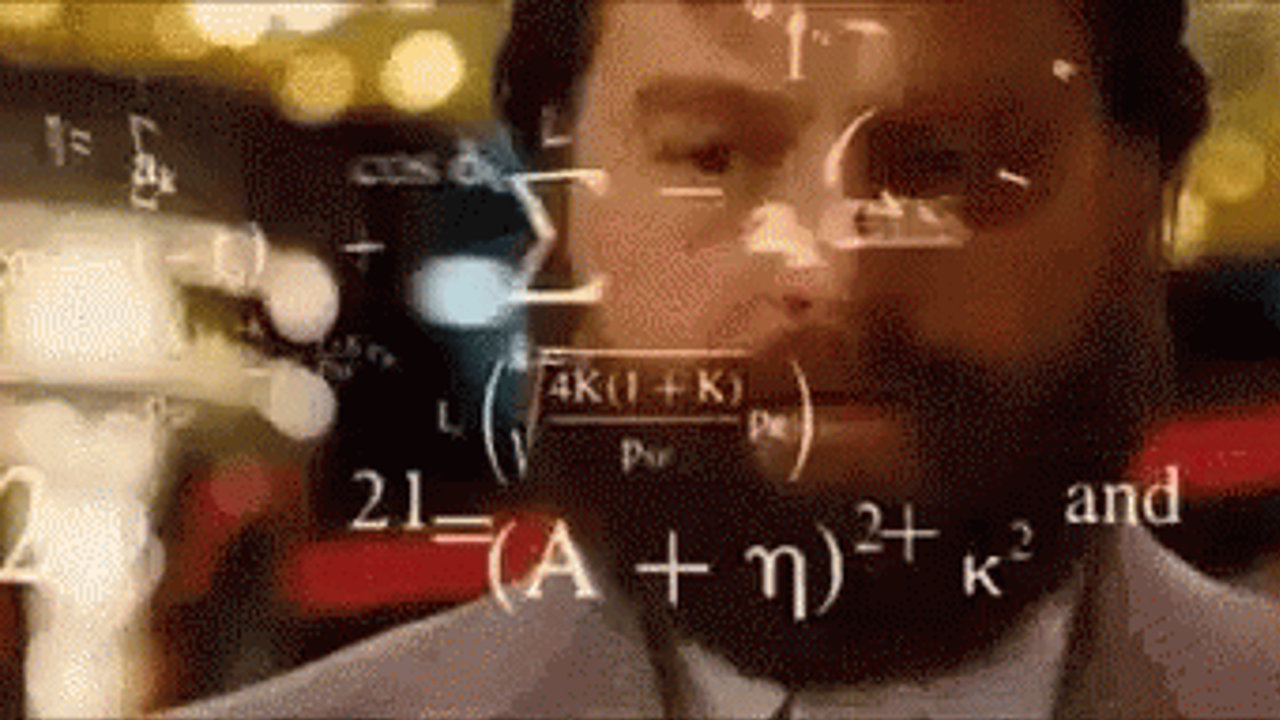

In [32]:
Image("images/mathcover.jpg")

Let's take it easy with [Towards Data Science article](https://towardsdatascience.com/latent-dirichlet-allocation-lda-9d1cd064ffa2)

**Model definition**

What we want to figure out are the words in different topics, as shown in the table below. Each row in the table represents a different topic and each column a different word in the corpus. Each cell contains the probability that the word(column) belongs to the topic(row).

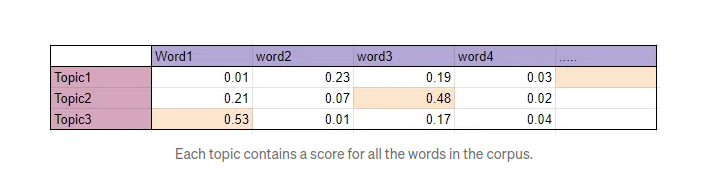

In [33]:
Image("images/Screenshot from 2023-11-05 21-12-38.png")

**How does LDA work?**

There are 2 parts in LDA:
- The words that belong to a document, that we already know.
- The words that belong to a topic or the probability of words belonging into a topic, that we need to calculate.

**The Algorithm to find the latter**

- Go through each document and randomly assign each word in the document to one of `k` topics (`k` is chosen beforehand).
- For each document `d`, go through each word `w` and compute :
    - p(topic `t` | document `d`): the proportion of words in document `d` that are assigned to topic `t`. Tries to capture how many words belong to the topic `t` for a given document `d`. Excluding the current word. If a lot of words from d belongs to t, it is more probable that word `w` belongs to t.( #words in d with t +alpha/ #words in d with any topic+ k*alpha)
    - p(word `w`| topic `t`): the proportion of assignments to topic `t` over all documents that come from this word `w`. Tries to capture how many documents are in topic t because of word `w`. LDA represents documents as a mixture of topics. Similarly, a topic is a mixture of words. If a word has high probability of being in a topic, all the documents having `w` will be more strongly associated with `t` as well. Similarly, if `w` is not very probable to be in `t`, the documents which contain the `w` will be having very low probability of being in `t`, because rest of the words in `d` will belong to some other topic and hence `d` will have a higher probability for those topic. So even if `w` gets added to `t`, it won’t be bringing many such documents to `t`.
- Update the probability for the word w belonging to topic t, as: p(word `w` with topic `t`) = p(topic `t` | document `d`) * p(word `w` | topic `t`)

In [34]:
all_stopwords_puncts = set(ru_stopwords) | set(string.punctuation) | set(ua_stopwords)

In [35]:
docs = []
for d in tqdm(df.iloc[random_ids]['content_processed'].to_list()):
    docs.append(
        [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in all_stopwords_puncts]
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2000.59it/s]


In [36]:
# Create Dictionary
vocab = corpora.Dictionary(docs)
# doc2bow means Doc transformed to Bag of Words
corpus = [vocab.doc2bow(text) for text in docs]
# View
print(
    f"Text:\n{' '.join(docs[0])}\n\n"
    f"Text BOW:\n{corpus[0]}"
)

Text:
коломойский зрівняв розстріли євреїв нацистами судом « слідство пише громадянин україни ставитися громадянина ізраїлю громадянина ізраїлю ставитеся чином слідчі дії судові процеси підпадають дати євреїв » — заявив коломойський провідомляє кореспондент новини.live нині засіданні триває перерва

Text BOW:
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 1)]


In [37]:
# number of topics
num_topics = 40
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics)
# Print the Keyword in the 40 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(29,
  '0.008*"»" + 0.007*"«" + 0.005*"–" + 0.005*"’" + 0.005*"``" + '
  '0.005*"україни" + 0.005*"—" + 0.004*"\'\'" + 0.004*"підписатися" + '
  '0.004*"новину"'),
 (12,
  '0.006*"»" + 0.005*"«" + 0.004*"—" + 0.003*"–" + 0.003*"києві" + 0.003*"👉" + '
  '0.003*"київ" + 0.003*"🔹" + 0.003*"новину" + 0.003*"підписатися"'),
 (6,
  '0.009*"»" + 0.008*"«" + 0.006*"київ" + 0.006*"гривень" + 0.005*"новину" + '
  '0.005*"—" + 0.004*"надіслати" + 0.003*"``" + 0.003*"\'\'" + 0.003*"києві"'),
 (22,
  '0.007*"—" + 0.007*"київ" + 0.006*"»" + 0.006*"«" + 0.005*"``" + '
  '0.005*"\'\'" + 0.004*"києві" + 0.003*"’" + 0.003*"великий" + '
  '0.003*"приєднатися"'),
 (26,
  '0.009*"«" + 0.008*"»" + 0.004*"’" + 0.003*"🇺🇦" + 0.003*"``" + 0.003*"киев" '
  '+ 0.003*"telegram" + 0.003*"facebook" + 0.002*"—" + 0.002*"\'\'"'),
 (17,
  '0.006*"новину" + 0.006*"—" + 0.006*"підписатися" + 0.005*"надіслати" + '
  '0.005*"київ" + 0.003*"ㅤ." + 0.003*"novosti_kieva_bot" + 0.003*"👉" + '
  '0.003*"києві" + 0.003*"вул"'),
 

In [38]:
# Visualize the topics
# pyLDAvis.enable_notebook()

# LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, vocab)
# LDAvis_prepared

## [BERTopic](https://github.com/MaartenGr/BERTopic)

BERTopic is a topic modeling technique that leverages transformers and c-TF-IDF to create dense clusters allowing for easily interpretable topics whilst keeping important words in the topic descriptions.

Very good explanation of algorithm can be found in [official documentation](https://maartengr.github.io/BERTopic/algorithm/algorithm.html)

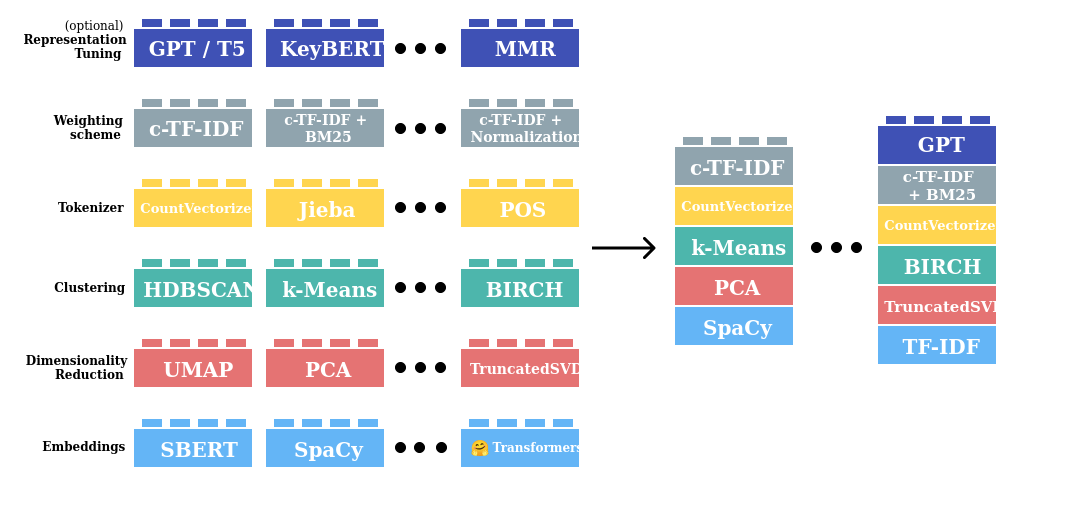

In [40]:
Image("images/Screenshot from 2023-11-05 21-45-36.png")

In [41]:
from bertopic import BERTopic
# TODO: Try different models and hyperparameters. Link https://github.com/MaartenGr/BERTopic 
topic_model = BERTopic(
    embedding_model="sentence-transformers/paraphrase-multilingual-mpnet-base-v2", 
    verbose=True
)

In [42]:
topics, probs = topic_model.fit_transform(df.iloc[random_ids]['content_processed'].to_list())

Batches:   0%|          | 0/94 [00:00<?, ?it/s]

2023-11-05 19:53:17,719 - BERTopic - Transformed documents to Embeddings
2023-11-05 19:53:39,196 - BERTopic - Reduced dimensionality
/home/vova/src/exps/iasa_nlp_course/.venv/lib/python3.10/site-packages/hdbscan/hdbscan_.py:1170: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  self._all_finite = is_finite(X)
2023-11-05 19:53:39,284 - BERTopic - Clustered reduced embeddings


In [43]:
topic_model.get_topic_info()

Topic  Count                                               Name  \
0      -1   1108                                     -1_на_та_до_за   
1       0    207                         0_бпла_ракети_ракет_новину   
2       1    110                1_підписатись_не_livе_запропонувати   
3       2    102                  2_київ_надіслати_пряма_трансляція   
4       3     86                                   3_київ_та_млн_на   
5       4     71                                4_дтп_водій_на_киев   
6       5     61                    5_вибухи_вибух_районі_предметів   
7       6     52                      6_будинку_будинок_пам_будівлі   
8       7     50                 7_виставку_тризуб_батьківщина_мати   
9       8     49                      8_навчання_кіно_режисер_вступ   
10      9     49                   9_сезону_опалювального_зими_зиму   
11     10     46                   10_температура_вдень_вночі_вітер   
12     11     46               11_окупанти_обстріляли_ова_внаслідок   
13     12     46                       12_загинув_пам_матвієнко_був   
14     13     43                     13_пожежа_пожежу_горить_пожежі   
15     14     38                          14_озера_синє_водою_озеро   
16     15     36                            15_нашої_прапор_ми_днем   
17     16     35       16_патрульні_інспектори_поліцейські_охоронці   
18     17     34            17_перейменування_проспект_депутатів_єс   
19     18     33                            18_млрд_грн_млн_бюджету   
20     19     33                       19_вагони_укрзалізниця_05_30   
21     20     32                  20_дитина_поверху_річна_врятувати   
22     21     30                      21_оболонь_життя_доброго_всім   
23     22     28                         22_кмда_корупції_бувший_дп   
24     23     28                              23_сбу_рф_про_підозру   
25     24     26           24_qr_перепустки_перепусток_правопорядку   
26     25     26                        25_вул_просп_автобусів_далі   
27     26     26                      26_ізраїлю_хамас_ізраїль_гази   
28     27     25                           27_тварин_оленя_не_dream   
29     28     25           28_викрили_call_діяльність_правоохоронці   
30     29     24              29_дітей_інвалідністю_таборі_дитячому   
31     30     23                           30_грн_банки_знижкою_трк   
32     31     23                          31_років_суд_області_суду   
33     32     22                      32_польща_польщі_єс_президент   
34     33     22              33_українські_бійці_окупантів_бригади   
35     34     22                      34_мостів_балок_міст_мостових   
36     35     21                35_затримали_до_народження_чоловіка   
37     36     20                      36_кмда_мітинг_вимагають_люди   
38     37     20                       37_ремонт_гривень_млн_роботи   
39     38     19                       38_гроші_данным_жінка_хабарі   
40     39     18                       39_mcdonald_кафе_меню_заклад   
41     40     17                   40_мопедів_загроза_будьте_уважно   
42     41     16                              41_the_ізраїлю_of_and   
43     42     16         42_рух_відновлено_затримується_тролейбусів   
44     43     16                    43_уламків_падіння_уламки_впали   
45     44     14                          44_любят_депутатка_не_его   
46     45     14              45_обліку_кордон_виїзд_військовозобов   
47     46     13            46_затримується_рух_трамваїв_відновлено   
48     47     13  47_novosti_kieva_bot_надіслати_підписатися_новину   
49     48     12            48_електропостачання_света_дтек_сильний   
50     49     11                    49_укрпошта_марку_монети_купюри   
51     50     11                     50_переговори_україна_що_війна   
52     51     11                   51_оболонь_життя_оболоні_метафор   
53     52     11                     52_острові_права_площею_оренди   
54     53     10                 53_фламінго_пташенят_зоопарку_тоні   

                           

In [ ]:
topic_model.get_topic(6)

In [ ]:
# topic_model.visualize_topics()

> **TODO**: Try to apply different algorithms, as proposed in [Code Overview](https://maartengr.github.io/BERTopic/algorithm/algorithm.html#code-overview)

## Conclusions 

**Use Cases**
- Finding topics in big corpuses 
- Finding keywords for better topic configuration 

**Main Problems**
- Requires hard hyper-parameter tunning  
- Old prototypes work much worse comparing to new ones (Neural Nets + Clustering + TfIdf)
- May require decompostition on steps and each step twicking 

<a id='Homework'></a>
# Homework

Theory (5 points):
- Complete theory questions in Google Form
- Take a look at all the links 
- Read and analyze all theory `TODO`s

Practice (10 points):
1. Take 2-3 channels from `KyivChannels_Dataset_v01`
2. Apply Clustering OR/AND Topic Modelling techniques to find topics of these channels. Ideal output: `channel_name:[topic_1, topic_2, topic_3]`. Examples: `Крипта Миколи : [криптовалюта, біржа]`
3. (Advanced) Try to come up with a universal approach
4. (Advanced) Apply your approach on other channels